In [118]:
import requests 
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
from scipy import stats as scistats

import lmoments3 as lm
from lmoments3 import stats, distr

import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

In [76]:
ds = xr.open_dataset('./data/ERA5-WRF_45km_monthly.nc')
ds

<xarray.Dataset>
Dimensions:            (time: 852, y: 104, x: 109)
Coordinates:
  * time               (time) datetime64[ns] 1950-09-01 ... 2021-08-01
    Lambert_Conformal  int32 ...
    lakemask           (y, x) float32 ...
    landmask           (y, x) float32 ...
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
  * x                  (x) float64 -6.285e+06 -6.24e+06 ... -1.47e+06 -1.425e+06
  * y                  (y) float64 -1.126e+06 -1.081e+06 ... 3.464e+06 3.509e+06
Data variables:
    T2                 (time, y, x) float32 ...

In [3]:
ds['T2'].data = (ds['T2'].data - 273.15) * (9/5) + 32
ds['T2'].attrs['units'] = 'F'

In [18]:
da = ds['T2']

In [19]:
ams = da.groupby('time.year').max('time')

In [46]:
ams

<xarray.DataArray 'T2' (year: 72, y: 104, x: 109)>
array([[[77.543655, 77.61831 , 77.71971 , ..., 80.92734 , 80.97024 ,
         80.943436],
        [77.627045, 77.98196 , 78.1145  , ..., 80.98804 , 81.03506 ,
         80.9821  ],
        [77.689224, 78.025955, 78.15741 , ..., 81.02528 , 80.96205 ,
         80.9603  ],
        ...,
        [72.69836 , 72.37261 , 71.852295, ..., 34.504112, 33.401417,
         32.990803],
        [72.4978  , 72.08252 , 71.496124, ..., 33.428387, 33.43745 ,
         32.302013],
        [72.18596 , 71.67256 , 71.06831 , ..., 32.814747, 32.442528,
         32.291576]],

       [[79.8125  , 79.8649  , 79.92642 , ..., 83.31703 , 83.276764,
         83.260284],
        [79.9429  , 80.275024, 80.25151 , ..., 83.61151 , 83.5328  ,
         83.306046],
        [79.99196 , 80.381096, 80.3667  , ..., 83.824814, 83.66084 ,
         83.420074],
...
        [75.444275, 75.29146 , 75.01933 , ..., 59.63331 , 59.111237,
         57.907356],
        [75.388306, 75.242676, 74.94704 , ..., 58.578453, 58.278145,
         56.868652],
        [75.31415 , 75.12535 , 74.90062 , ..., 57.110954, 56.71512 ,
         57.304535]],

       [[79.81436 , 79.877045, 79.871   , ..., 83.163055, 83.04962 ,
         82.96228 ],
        [79.799866, 79.88644 , 79.81738 , ..., 83.44568 , 83.32225 ,
         82.795395],
        [79.650665, 79.744934, 79.66182 , ..., 83.42513 , 83.238205,
         82.67037 ],
        ...,
        [75.5047  , 75.60924 , 75.61957 , ..., 52.49928 , 51.645256,
         50.039165],
        [75.61078 , 75.714264, 75.66966 , ..., 51.635204, 50.8415  ,
         49.24815 ],
        [75.7408  , 75.71136 , 75.60083 , ..., 50.106182, 49.35972 ,
         49.366364]]], dtype=float32)
Coordinates:
    Lambert_Conformal  int32 1
    lakemask           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    landmask           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 9.476 9.693 9.909 ... 67.02 67.18 67.33
    lon                (y, x) float32 -123.5 -123.2 -123.0 ... -103.3 -102.4
  * x                  (x) float64 -6.285e+06 -6.24e+06 ... -1.47e+06 -1.425e+06
  * y                  (y) float64 -1.126e+06 -1.081e+06 ... 3.464e+06 3.509e+06
  * year               (year) int64 1950 1951 1952 1953 ... 2018 2019 2020 2021

In [72]:
stations = pd.read_csv('./data/weather_stations.csv')
stations.head()

,STATE,STATION,CITY,FAA,LAT_Y,LON_X
0,CA,BAKERSFIELD MEADOWS FIELD,BAKERSFIELD,KBFL,35.43424,-119.05524
1,CA,BLYTHE ASOS,BLYTHE,KBLH,33.61876,-114.71451
2,CA,BURBANK-GLENDALE-PASADENA AIRPORT,BURBANK,KBUR,34.19966,-118.36543
3,CA,LOS ANGELES DOWNTOWN USC CAMPUS,LOS ANGELES DOWNTOWN,KCQT,34.02360,-118.29110
4,CA,NEEDLES AIRPORT,NEEDLES,KEED,34.76783,-114.61842


In [97]:
lon = stations.LON_X[0]
lat = stations.LAT_Y[0]

In [98]:
# pull projection values from netcdf file
projection = ccrs.LambertConformal(central_longitude=-70,
                             central_latitude=38,
                             standard_parallels=[30., 60.])

#function to transform points accordingly
transform = np.vectorize(lambda x, y: projection.transform_point(x, y, ccrs.PlateCarree()))

desired_x, desired_y = transform(lon, lat)

In [99]:
ams_at_point = ams.sel(x=desired_x, y=desired_y, method='nearest')
ams_at_point

<xarray.DataArray 'T2' (year: 72)>
array([68.29229 , 73.79754 , 74.74527 , 78.612625, 78.46651 , 76.648605,
       72.8208  , 75.35689 , 76.713196, 77.5063  , 76.59883 , 77.1304  ,
       74.3456  , 73.665375, 74.65765 , 73.00668 , 75.37952 , 79.03439 ,
       76.1122  , 77.43225 , 77.18929 , 75.93323 , 76.29237 , 74.04918 ,
       74.58361 , 72.474625, 72.43326 , 75.17792 , 73.36813 , 73.63549 ,
       77.12068 , 77.04384 , 74.304886, 75.45137 , 79.33728 , 79.145294,
       77.23983 , 73.32782 , 78.2543  , 75.970856, 77.32492 , 75.116394,
       77.46615 , 72.51466 , 76.63223 , 76.545334, 78.10121 , 73.74524 ,
       78.16675 , 73.22125 , 75.28328 , 74.90419 , 75.823364, 78.193665,
       74.57141 , 78.68964 , 80.74447 , 74.884796, 76.37845 , 76.422775,
       73.41582 , 73.781555, 77.741905, 76.653435, 75.98437 , 75.346886,
       76.23013 , 79.93494 , 79.14574 , 76.96435 , 79.357445, 78.816315],
      dtype=float32)
Coordinates:
    Lambert_Conformal  int32 1
    lakemask           float32 0.0
    landmask           float32 1.0
    lat                float32 35.63
    lon                float32 -119.1
    x                  float64 -4.08e+06
    y                  float64 1.034e+06
  * year               (year) int64 1950 1951 1952 1953 ... 2018 2019 2020 2021

In [108]:
paras_gev = distr.gev.lmom_fit(ams_at_point)
paras_gum = distr.gum.lmom_fit(ams_at_point)
paras_wei = distr.wei.lmom_fit(ams_at_point)
paras_gam = distr.gam.lmom_fit(ams_at_point)
paras_gpa = distr.gpa.lmom_fit(ams_at_point)
paras_exp = distr.exp.lmom_fit(ams_at_point)
paras_glo = distr.glo.lmom_fit(ams_at_point)
paras_pe3 = distr.pe3.lmom_fit(ams_at_point)

In [101]:
print('gev AICc:', stats.AICc(ams_at_point, 'gev', paras_gev))
print('gum AICc:', stats.AICc(ams_at_point, 'gum', paras_gum))
print('wei AICc:', stats.AICc(ams_at_point, 'wei', paras_wei))
print('gam AICc:', stats.AICc(ams_at_point, 'gam', paras_gam))
print('gpa AICc:', stats.AICc(ams_at_point, 'gpa', paras_gpa))
print('exp AICc:', stats.AICc(ams_at_point, 'exp', paras_exp))
print('glo AICc:', stats.AICc(ams_at_point, 'glo', paras_glo))
print('pe3 AICc:', stats.AICc(ams_at_point, 'pe3', paras_pe3))

gev AICc: 323.14400912160204
gum AICc: 383.8751583428449
wei AICc: 325.2837696486924
gam AICc: 325.40759357375526
gpa AICc: inf
exp AICc: inf
glo AICc: 325.0074996956813
pe3 AICc: 323.20290162150576


In [102]:
fitted_gev = distr.gev(**paras_gev)

return_years = [2,5,10,20,50,100,200,500,1000]
return_periods = np.empty(len(return_years))

for i in range(len(return_years)):
    return_periods[i] = 1.0-(1.0/return_years[i])

gev_return_periods = fitted_gev.ppf(return_periods)

In [116]:
lm.lmom_fit(ams_at_point)

AttributeError: module 'lmoments3' has no attribute 'lmom_fit'

In [141]:
paras_list = distr.gev.lmom_fit(ams_at_point)
paras_list['c']

0.35492408681465815

In [139]:
paras_list

OrderedDict([('c', 0.35492408681465815),
             ('loc', 75.27721455138726),
             ('scale', 2.290334288706858)])

In [143]:
scistats.genextreme.pdf(ams_at_point, paras_list['c'], paras_list['loc'], paras_list['scale'])

array([0.00061464, 0.10619413, 0.14445682, 0.10231763, 0.10924478,
       0.16981775, 0.06562275, 0.1625321 , 0.16893832, 0.14928067,
       0.17041531, 0.1605345 , 0.12927506, 0.10048863, 0.14130958,
       0.07287283, 0.16304714, 0.08203709, 0.17250635, 0.15174612,
       0.15898753, 0.17155633, 0.172531  , 0.11698027, 0.13856331,
       0.05308331, 0.05167824, 0.15803999, 0.0877607 , 0.09919952,
       0.16078164, 0.16265235, 0.12762659, 0.16460037, 0.06769055,
       0.07673561, 0.1575933 , 0.08605958, 0.11905982, 0.17183191,
       0.15511051, 0.15633163, 0.15063176, 0.05446313, 0.17002204,
       0.17097914, 0.12588521, 0.10393659, 0.12299408, 0.08160573,
       0.16077315, 0.14985031, 0.17052379, 0.12179294, 0.13810369,
       0.09863094, 0.01428432, 0.14921538, 0.17221054, 0.17196179,
       0.08978276, 0.10550438, 0.14071774, 0.16975604, 0.17192107,
       0.16230056, 0.17262883, 0.04153725, 0.07671456, 0.16442905,
       0.06675346, 0.09253633])

In [170]:
paras_gum = distr.gum.lmom_fit(ams_at_point)
fitted_gum = distr.gum(**paras_gum)
fitted_gum.ppf()

TypeError: ppf() missing 1 required positional argument: 'q'

In [167]:
dir(lm.distr.gev.ppf)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [177]:
paras_gev = distr.gev.lmom_fit(ams_at_point)
fitted_gev = scistats.genextreme(**paras_gev)
fitted_gev.ppf(1.0-(1.0/75))
#scistats.genextreme.ppf((1.0-(1.0/75)), paras_gev['c'], paras_gev['loc'], paras_gev['scale'])

80.33293165891675

In [207]:
fig, ax = plt.subplots(1, 1)

ax.plot(x, genextreme.pdf(x, c),
       'r-', lw=5, alpha=0.6, label='genextreme pdf')

AttributeError: 'rv_frozen' object has no attribute 'plot'

In [197]:
scistats.kstest(ams_at_point, 'genextreme', args=(paras_gev['c'], paras_gev['loc'], paras_gev['scale']))

KstestResult(statistic=0.04706330952344961, pvalue=0.9950410130373191)

In [185]:
scistats.kstest(x=fitted_gev, fitted_gev.cdf())

SyntaxError: positional argument follows keyword argument (4195428208.py, line 1)

In [181]:
print(*paras_gev)

c loc scale


In [176]:
paras_gev = distr.gev.lmom_fit(ams_at_point)
fitted_gev = distr.gev(**paras_gev)
fitted_gev.ppf(1.0-(1.0/75))

80.33293165891675

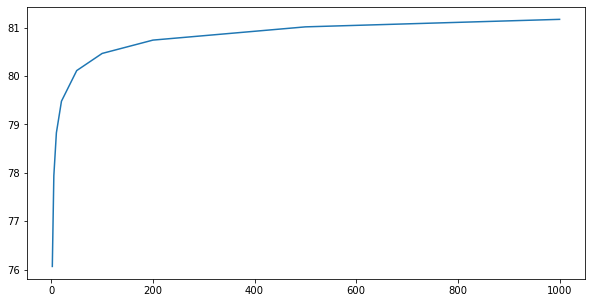

In [104]:
plt.figure(figsize=[10,5]) 
plt.plot(return_years, gev_return_periods)

plt.show()

In [ ]:
paras_gev = distr.gev.lmom_fit(ams_at_point)
lm.stats

In [106]:
import warnings as _warnings
from collections import OrderedDict
from numpy.random import randint as _randint

class InstabilityWarning(UserWarning):
    """Issued when results may be unstable."""
    pass

_warnings.simplefilter('always', InstabilityWarning)
_warnings.simplefilter('always', UserWarning)

In [107]:
def bootstrap_ci(data, statfunction=np.average, alpha = 0.05, 
                 n_samples = 100):
    """
    Given a set of data ``data``, and a statistics function ``statfunction`` that
    applies to that data, computes the bootstrap confidence interval for
    ``statfunction`` on that data. Data points are assumed to be delineated by
    axis 0.
    
    This function has been derived and simplified from scikits-bootstrap 
    package created by cgevans (https://github.com/cgevans/scikits-bootstrap).
    All the credits shall go to him.
    **Parameters**
    
    data : array_like, shape (N, ...) OR tuple of array_like all with shape (N, ...)
        Input data. Data points are assumed to be delineated by axis 0. Beyond this,
        the shape doesn't matter, so long as ``statfunction`` can be applied to the
        array. If a tuple of array_likes is passed, then samples from each array (along
        axis 0) are passed in order as separate parameters to the statfunction. The
        type of data (single array or tuple of arrays) can be explicitly specified
        by the multi parameter.
    statfunction : function (data, weights = (weights, optional)) -> value
        This function should accept samples of data from ``data``. It is applied
        to these samples individually. 
    alpha : float, optional
        The percentiles to use for the confidence interval (default=0.05). The 
        returned values are (alpha/2, 1-alpha/2) percentile confidence
        intervals. 
    n_samples : int or float, optional
        The number of bootstrap samples to use (default=100)
        
    **Returns**
    
    confidences : tuple of floats
        The confidence percentiles specified by alpha
    **Calculation Methods**
    
    'pi' : Percentile Interval (Efron 13.3)
        The percentile interval method simply returns the 100*alphath bootstrap
        sample's values for the statistic. This is an extremely simple method of 
        confidence interval calculation. However, it has several disadvantages 
        compared to the bias-corrected accelerated method.
        
        If you want to use more complex calculation methods, please, see
        `scikits-bootstrap package 
        <https://github.com/cgevans/scikits-bootstrap>`_.
    **References**

    
        Efron (1993): 'An Introduction to the Bootstrap', Chapman & Hall.
    """

    def bootstrap_indexes(data, n_samples=10000):
        """
    Given data points data, where axis 0 is considered to delineate points, return
    an generator for sets of bootstrap indexes. This can be used as a list
    of bootstrap indexes (with list(bootstrap_indexes(data))) as well.
        """
        for _ in range(n_samples):
            yield _randint(data.shape[0], size=(data.shape[0],))    
    
    alphas = np.array([alpha / 2,1 - alpha / 2])

    data = np.array(data)
    tdata = (data,)
    
    # We don't need to generate actual samples; that would take more memory.
    # Instead, we can generate just the indexes, and then apply the statfun
    # to those indexes.
    bootindexes = bootstrap_indexes(tdata[0], n_samples)
    stat = np.array([statfunction(*(x[indexes] for x in tdata)) for indexes in bootindexes])
    stat.sort(axis=0)

    # Percentile Interval Method
    avals = alphas

    nvals = np.round((n_samples - 1)*avals).astype('int')

    if np.any(nvals == 0) or np.any(nvals == n_samples - 1):
        _warnings.warn("Some values used extremal samples; results are probably unstable.", InstabilityWarning)
    elif np.any(nvals<10) or np.any(nvals>=n_samples-10):
        _warnings.warn("Some values used top 10 low/high samples; results may be unstable.", InstabilityWarning)

    if nvals.ndim == 1:
        # All nvals are the same. Simple broadcasting
        return stat[nvals]
    else:
        # Nvals are different for each data point. Not simple broadcasting.
        # Each set of nvals along axis 0 corresponds to the data at the same
        # point in other axes.
        return stat[(nvals, np.indices(nvals.shape)[1:].squeeze())]

In [ ]:
def ci_bootstrap(df, gevfit):
    # Calculate confidence intervals using parametric bootstrap and the
    # percentil interval method
    # This is used to obtain confidence intervals for the estimators and
    # the return values for several return values.    
    # More info about bootstrapping can be found on:
    #     - https://github.com/cgevans/scikits-bootstrap
    #     - Efron: "An Introduction to the Bootstrap", Chapman & Hall (1993)
    #     - https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29

    # parametric bootstrap for return levels and parameters 
    
    paras_burbank = distr.gev.lmom_fit(ams_burbank)
    gev_burbank = distr.gev(**paras_burbank)

    # The function to bootstrap     
    def func(data):
        sample = lmoments.randgev(len(df.index), gevfit)
        samgevfit = lmoments.pelgev(paras_gev = distr.gev.lmom_fit(ams_at_point))      
                
        T = np.arange(0.1, 999.1, 0.1) + 1
        sT = lmoments.quagev(1.0-1./T, samgevfit)
        res = samgevfit
        res.extend(sT.tolist())
        return tuple(res)

    # the calculations itself
    out = bootstrap_ci(df, statfunction = func, n_samples = 500)
    ci_Td = out[0, 3:]
    ci_Tu = out[1, 3:]
    params_ci = OrderedDict()
    params_ci['shape']    = (out[0,0], out[1,0])
    params_ci['location'] = (out[0,1], out[1,1])
    params_ci['scale']    = (out[0,2], out[1,3])
    
    return{'ci_Td':ci_Td, 'ci_Tu':ci_Tu, 'params_ci':params_ci}